# INSTRUCTIONS

* Make sure to run all the cells before trying to train the model.
* See the "Network code" section for a description of what each argument is
    for the neural network. 
* Everything you need is in the "Set hyperparameters, train model, see results" 
    section: all the hyperparameters to play with
* Let me know if something isn't working or if you have questions
* USE PYTHON 3


* **IMPORTANT** As you're training the model, it will show you how the training and validation
    RMSEs change over time. If you see the model isn't improving anymore, just hit 
    "Kernel" -> "Interrupt Kernel" at the bar up top. The training method catches 
    the exception and will return just fine. 
* Also try running the "Side experiment" section if u want

* **TIPS**: 
    * if the validation/training RMSEs are fluctuating a lot, lower the learning rate. It needs to be pretty low for the learning dynamic to be stable
    * Try varying the number of hidden units per layer; that seems to work pretty well for me
    * Be suspicious if the training RMSE is much lower than the validation RMSE - if you make the network huge (without enough regularization), it can "memorize" the training set and will do horribly on the test set

# Imports

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.get_data import *
from IPython.display import clear_output, display
from ipywidgets import IntProgress
from collections import OrderedDict
import warnings
import time
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.linear_model import Ridge

# Load data

In [2]:
%load_ext autoreload
%autoreload 2

b_data, u_data, train_reviews = get_training_data(b_cols='maybe', verbose=True)
valid_reviews = get_validation_reviews()

# due to quirks with how PyTorch works, I have to subtract one from the stars, 
#   so that they range from [0, 4]
train_reviews['stars'] -= 1
valid_reviews['stars'] -= 1

X_train, y_train = construct_design_matrix(
    b_data, u_data, train_reviews, return_df=False, verbose=True
)
X_valid, y_valid = construct_design_matrix(
    b_data, u_data, valid_reviews, return_df=False, verbose=True
)

========== Feature 'attributes_AcceptsInsurance' ==========
TYPE: boolean. Changing False -> 0, True -> 1.
Detected NaN in column. Replacing with mean of non-NaN values.

========== Feature 'attributes_AgesAllowed' ==========
TYPE: string. Doing one-hot encoding.

========== Feature 'attributes_Alcohol' ==========
TYPE: string. Doing one-hot encoding.

========== Feature 'attributes_Ambience' ==========
TYPE: dict. Creating new features and doing one-hot encoding.

========== Feature 'attributes_BusinessParking' ==========
TYPE: dict. Creating new features and doing one-hot encoding.

========== Feature 'attributes_Caters' ==========
TYPE: boolean. Changing False -> 0, True -> 1.
Detected NaN in column. Replacing with mean of non-NaN values.

========== Feature 'attributes_DogsAllowed' ==========
TYPE: boolean. Changing False -> 0, True -> 1.
Detected NaN in column. Replacing with mean of non-NaN values.

========== Feature 'attributes_GoodForDancing' ==========
TYPE: boolean. Changing

# Network code

In [175]:
class FFNN(nn.Module):
    """
    Feed forward neural network.
    
    === PARAMETERS ===============================================================
    
    (int) in_size: number of input features
    
    (int) num_hidden_layers: number of hidden layers.
    
    (int or list/np.array) hidden_size: number of hidden units.
                * if hidden_size=int, then each hidden layer has that many units.
                * if it is a list/array, then it specifies the number of hidden
                    units for EACH layer.
                                
    (string) model_type: "softmax" or "regression"
                                
    (int) out_size: number of output units (5 for softmax, 1 for regression)
    
    (bool) do_batchnorm: have not implemented this, ignore it
    
    (bool) do_dropout: do dropout training (adds dropout layers). You can ignore this
            if you want, it makes training tricky
            
    (float) p: dropout probability
    
    =================================================================================
    
    
    TODO: batchnorm (maybe not tho)
    """
    
    def __init__(
        self, in_size, hidden_size, num_hidden_layers, out_size, activation,
        model_type, do_batchnorm=True, do_dropout=True, p=0.3
    ):
        super(FFNN, self).__init__()
        self.model_type = model_type
        msg = 'Unknown model type %s' % model_type
        assert model_type in ['softmax', 'regression'], msg
        
        self.in_size = in_size
        self.out_size = out_size
        
        self.num_hidden_layers = num_hidden_layers
        if type(hidden_size) is int:
            self.hidden_size = [hidden_size]*num_hidden_layers
        elif type(hidden_size) in [list, np.ndarray]:
            msg = "num_hidden_layers != len(hidden_size) " 
            assert len(hidden_size) == num_hidden_layers, msg
        else:
            msg = "OOPS: hidden_size should be an int, list, or np.array"
            msg = msg + '\nhidden_size = %s ?' % hidden_size
            raise ValueError(msg)
        
        
        self.layers = OrderedDict()
        if do_dropout:
            self.layers['dropout_in'] = nn.Dropout(p=0.15)
        self.layers['linear_in'] = nn.Linear(in_size, hidden_size[0])
        self.layers['activ_in'] = activation()
        
        for i in range(1, num_hidden_layers):
            if do_dropout:
                self.layers['dropout_%d' % i] = nn.Dropout(p=p)
            self.layers['linear_%d' % i] = nn.Linear(
                hidden_size[i-1], hidden_size[i]
            )
            self.layers['activ_%d' % i] = activation()
            
        self.layers['linear_out'] = nn.Linear(hidden_size[-1], out_size)
        
        self.model = nn.Sequential(self.layers)
        
    def forward(self, x):    
        return self.model(x)
    
    def predict(self, x, return_probs=False):
        """
        Returns class predictions for each data point in x - a numpy array of shape
            (len(x), ).
        
        If return_probs=True, returns class probabilities instead - as a numpy array 
            of size ( len(x), num_classes ).
        """
        N = x.shape[0]
        
        if isinstance(x, Variable):
            scores = self.model(x).data.numpy()
        elif isinstance(x, torch.Tensor):
            scores = self.model(x).numpy()
        else:
            scores = self.model(torch.FloatTensor(x)).detach().numpy()
            
        if self.model_type == 'regression':
            return scores.squeeze()
        
        try:
            probs = np.exp(scores.astype(np.float64)) # avoid overflow errors
        except:
            print(scores.dtype)
            print(scores.min(), scores.max())
            raise
            
        try:
            probs /= probs.sum(axis=1).reshape(N, 1)
        except:
            print(probs.shape)
            print(np.isnan(scores).any())
            print(np.isnan(probs.sum(axis=1)).any())
            raise
        
        if return_probs:
            return probs
        
        predictions = probs.argmax(axis=1)
        return predictions
    
    def get_hidden_representations(self, x):
        x = torch.Tensor(x)

        reps = []
        for name, layer in self.layers.items():
            x = layer(x)
            if 'activ' in name or 'out' in name:
                reps.append(x.detach().numpy())
                
        
        return reps
            
        

# Helper functions

In [161]:
def calculate_accuracy(model, X, y):
    """ Calculate the accuracy on the FULL data X and y. """
    y_pred = np.zeros_like(y)
    for i in range(0, X.shape[0], 100):
        x_in = X[i:i+100]
        
        y_out = model.predict(x_in)
        
        y_pred[i:i+100] = y_out
        
    accuracy = np.mean(np.where(y_pred == y, 1, 0))
    return accuracy

def calculate_rmse(model, X, y):
    """ Calculate the RMSE on the FULL data X and y. """
    y_pred = np.zeros_like(y)
    for i in range(0, X.shape[0], 100):
        x_in = X[i:i+100]
        
        y_out = model.predict(x_in)
        
        y_pred[i:i+100] = y_out
        
    rmse = np.sqrt(np.mean((y - y_pred)**2))
    return rmse

def sample_rmse(model, X, y, n_samples=1000):
    """ 
    Calculate the RMSE on 'n_samples' randomly chosen data points from X and y. 
    """
    sample_idx = np.random.choice(X.shape[0], size=n_samples)
    X_s, y_s = X[sample_idx], y[sample_idx]
    
    y_pred = np.zeros_like(y_s)
    for i in range(0, X_s.shape[0], 100):
        x_in = X_s[i:i+100]
        
        y_out = model.predict(x_in)
        
        y_pred[i:i+100] = y_out
        
    rmse = np.sqrt(np.mean((y_s - y_pred)**2))
    return rmse

def moving_average(values, alpha=0.25):
    """ Exponential moving average """
    N = len(values)
    if N == 1:
        return values[0]
    
    weights = np.array([(1 - alpha)**i for i in range(len(values))])[::-1]
    return np.sum(weights * values) / np.sum(weights)

# class BestModels(object):
    
#     def __init__(self, track_how_many=5, keep_intervals=None):
#         self.models = dict()
#         self.track_how_many = track_how_many
#         self.keep_intervals = keep_intervals
        
#     def add(self, model, score, epoch):
        
#         self.models.append(model)
#         self.stats[model]

# Training method

In [173]:
def train(params, model_type='softmax'):
    # Unpack parameters
    if True:
        input_size = params['in_size']
        num_epochs = params['num_epochs']
        batch_size = params['batch_size']
        learning_rate = params['learning_rate']
        hidden_size = params['hidden_size']
        num_hidden_layers = params['num_hidden_layers']
        activation = params['activation']
        do_dropout = params['do_dropout']
        do_batchnorm = params['do_batchnorm'] 
        
    if model_type == 'softmax':
        output_size = 5
        criterion = nn.CrossEntropyLoss()
        t_tensor = lambda y_b: torch.LongTensor(y_b).reshape(-1, )
    elif model_type == 'regression':
        output_size = 1
        criterion = nn.MSELoss()
        t_tensor = lambda y_b: torch.FloatTensor(y_b).reshape(-1, 1)
    else:
        raise ValueError('Unknown model type %s.' % model_type)

    warnings.filterwarnings("error")

    model = FFNN(
        input_size, hidden_size, num_hidden_layers, output_size, activation,
        model_type, do_batchnorm, do_dropout
    )
    
    output = dict()
    output['log'] = []
    output['best_model'] = None
    output['best_rmse'] = np.inf

    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    stats = np.zeros((num_epochs, 5))
#     instability_measures = np.zeros(num_epochs)
    
    N = X_train.shape[0]
    num_batches = int(np.ceil(N / batch_size))

    epo_meter = IntProgress(min=0, max=num_epochs, description='Epoch:')
    btc_meter = IntProgress(min=0, max=num_batches, description='Batch:')
    display(epo_meter)
    display(btc_meter)

    try:
        for epoch in range(num_epochs):
            # shuffle review order
            shuf_idx = np.random.permutation(N)

            losses = []
            for b_num in range(num_batches):
                # Create batch
                b_begin, b_end = b_num * batch_size, (b_num+1) * batch_size
                batch_idx = shuf_idx[b_begin:b_end]

                X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
                X_batch = Variable(torch.FloatTensor(X_batch))
                y_batch = t_tensor(y_batch)

                # forward pass; compute loss
                outputs = model(X_batch)
                try:
                    loss = criterion(outputs, y_batch)
                except RuntimeError:
                    print(np.unique(y_batch.numpy()))
                    print(epoch, b_num)
                    raise

                # Backward pass; update parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.data.item())

                btc_meter.value += 1

            btc_meter.value = 0
            epo_meter.value += 1

            avg_loss = np.mean(losses)
            stats[epoch, 0] = avg_loss

            model.eval()
            try:
                train_rmse = calculate_rmse(model, X_train, y_train)
                stats[epoch, 1] = train_rmse
            except RuntimeWarning:
                message = 'Warning: NaN encountered doing train RMSE at epo %d' % epoch
                output['log'].append(message)
                print(message)
                time.sleep(0.25)

            valid_rmse = calculate_rmse(model, X_valid, y_valid)
            stats[epoch, 2] = valid_rmse

            if valid_rmse < output['best_rmse']:
                output['best_rmse'] = valid_rmse
                output['best_model'] = deepcopy(model)
                output['best_epoch'] = epoch + 1

            model.train()

            clear_output()
            display(epo_meter)
            display(btc_meter)

            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
            ax1.set_title('Stats vs epoch')
            ax1.plot(range(epoch+1), stats[:epoch+1, 1], label='Train RMSE')
            ax1.plot(range(epoch+1), stats[:epoch+1, 2], label='Valid RMSE')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('RMSE')
            ax1.legend(*ax1.get_legend_handles_labels())

            if epoch > 3:
                mn = max(0, epoch-20)
                xs = range(mn, epoch+1)
                recent_valid_rmses = stats[mn:epoch+1, 2]
                z = np.polyfit(xs, recent_valid_rmses, deg=1)
                p = np.poly1d(z)
                ax1.plot(xs, p(xs), color='red', linestyle='--')

            alpha = 0.25
            stats[epoch, 3] = moving_average(stats[:epoch+1, 1], alpha)
            stats[epoch, 4] = moving_average(stats[:epoch+1, 2], alpha)
            ax2.set_title('RMSE exponential moving averages (alpha=%.3f)' % alpha)
            ax2.set_xlabel('Epoch')
            ax2.plot(range(epoch+1), stats[:epoch+1, 3], label='EMA of train RMSE')
            ax2.plot(range(epoch+1), stats[:epoch+1, 4], label='EMA of valid RMSE')

            plt.legend()
            plt.show()


            instability = moving_average(
                np.sqrt((stats[:epoch+1, 3] - stats[:epoch+1, 1])**2)
            )
            print('Instability measure: %f' % instability)
            if epoch > 3:
                print(
                    'valid error decreasing (roughly on average) by %f/epoch ' % -z[0]
                )
            
    except KeyboardInterrupt:
        clear_output()
        print('Interrupted - returning early')

    epo_meter.close()
    btc_meter.close()

    model.eval() 
    warnings.filterwarnings("default")
    
    output['model'] = model
    output['stats'] = stats
    
    best_epo, best_err = output['best_epoch'], output['best_rmse']
    print('Best valid RMSE achieved: %f at epoch %d' % (best_err, best_epo))
    
    return output

# Set hyperparameters, train model, see results

# (DO STUFF HERE)

In [176]:
# Fixed
input_size = len(b_data.columns) + len(u_data.columns)

# Hyperparameters / architecture choices
num_epochs = 250       # <- need to train for a lot of epochs
batch_size = 100
learning_rate = 1e-4   
do_dropout = False
do_batchnorm = False   # ignore this, I haven't implemented it

hidden_size = [50, 40, 30, 20, 10]
num_hidden_layers = 5
activation = nn.ReLU

model_type = 'regression'  # regression seems to work better, but definitely try 
                           # softmax as well

# Pack parameters into dict
if True:
    params = dict()
    params['in_size'] = input_size
    params['out_size'] = output_size
    params['num_epochs'] = num_epochs
    params['batch_size'] = batch_size
    params['learning_rate'] = learning_rate
    params['hidden_size'] = hidden_size
    params['num_hidden_layers'] = num_hidden_layers
    params['activation'] = activation
    params['do_dropout'] = do_dropout
    params['do_batchnorm'] = do_batchnorm
    
results = train(params, model_type='regression')
model, stats = results['model'], results['stats']

Interrupted - returning early
Best valid RMSE achieved: 1.061195 at epoch 46


# Side experiment - do ridge regression with neural network's hidden representations

## this seems bugged tho - changing regularization strength isn't changing the results

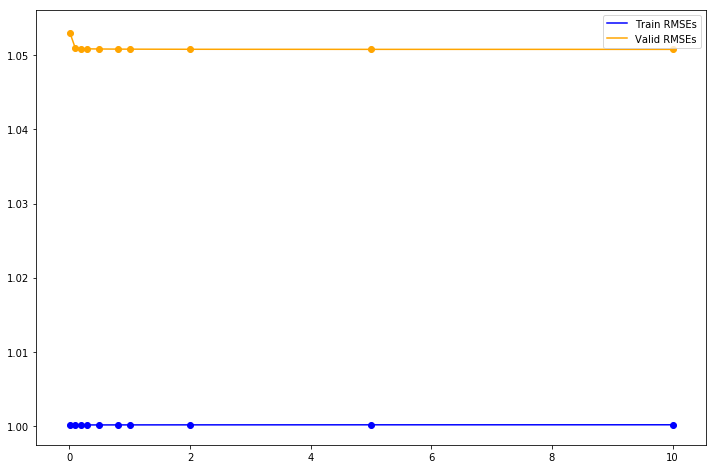

In [177]:
reps_v = results['best_model'].get_hidden_representations(X_valid)
reps_v = np.hstack(reps_v)
f_rep_v = np.hstack([X_valid, reps_v])

reps_t = results['best_model'].get_hidden_representations(X_train)
reps_t = np.hstack(reps_t)
f_rep_t = np.hstack([X_train, reps_t])

alphas = [0.01, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0]
valid_rmses = []
train_rmses = []

for alpha in alphas:
    print('Doing alpha=%f' % alpha)
    ridge = Ridge(alpha=alpha)
    ridge.fit(f_rep_t, y_train)

    y_pred_t = ridge.predict(f_rep_t)
    y_pred_v = ridge.predict(f_rep_v)
    
    c_rmse = lambda y1, y2: np.sqrt(np.mean((y1 - y2)**2))
    
    valid_rmses.append(c_rmse(y_pred_v, y_valid))
    train_rmses.append(c_rmse(y_pred_t, y_train))
    clear_output()
    
f, ax = plt.subplots(figsize=(12, 8))
ax.plot(alphas, train_rmses, label='Train RMSEs', color='blue')
ax.scatter(alphas, train_rmses, color='blue')
ax.plot(alphas, valid_rmses, label='Valid RMSEs', color='orange')
ax.scatter(alphas, valid_rmses, color='orange')
plt.legend()
plt.show()